# Voronoi analysis with OVITO

This notebook mirrors `voronoi_canon.ipynb` but uses OVITO's `VoronoiAnalysisModifier` via `voronoi_ovito_utils.py`.

- Build Voronoi graphs (full and metals-only)
- Summarize graph properties and clusters
- Compute coordination distributions

Note: Ensure OVITO and ASE are installed in this environment.


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from ovito.io import import_file

from voronoi_ovito_utils import (
    build_voronoi_graph_from_pipeline,
    build_voronoi_graph_metals_only_from_pipeline,
    analyze_graph_properties,
    analyze_voronoi_clusters,  # atoms-based version (kept for reference)
    analyze_voronoi_coordination_from_pipeline,
    analyze_temporal_graph_properties_from_pipeline,
    plot_temporal_graph_properties,
)



In [2]:
# Configure your input structure/trajectory file
input_path = '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.67/T1300K/dump.lammpstrj'  # TODO: Set path

# Load with OVITO pipeline
aae = import_file(input_path, multiple_frames=True)
print(f"Loaded trajectory with {aae.source.num_frames} frames")
frame = 0  # choose frame index

# Compute once to confirm cell/PBC and show basic info
data0 = aae.compute(frame)
print('Cell matrix:')
print(np.array(data0.cell.matrix))
print('PBC:', tuple(bool(x) for x in data0.cell.pbc))



Loaded trajectory with 24594 frames
Cell matrix:
[[39.91194797  0.          0.         -0.10608264]
 [ 0.         39.91194797  0.         -0.10608264]
 [ 0.          0.         39.91194797 -0.10608264]]
PBC: (True, True, True)


Graph properties (full): {'num_nodes': 1920, 'num_edges': 14298, 'density': 0.0077612037519541426, 'species_counts': {'Pu': 384, 'Cl': 1344, 'Na': 192}, 'is_connected': True, 'diameter': 9, 'radius': 8, 'avg_degree': 14.89375, 'std_degree': 2.780168328986574, 'max_degree': 23, 'min_degree': 7, 'species_avg_degrees': {'Pu': 10.895833333333334, 'Cl': 16.151041666666668, 'Na': 14.088541666666666}, 'avg_facet_area': 0.0, 'std_facet_area': 0.0, 'min_facet_area': 0.0, 'max_facet_area': 0.0}


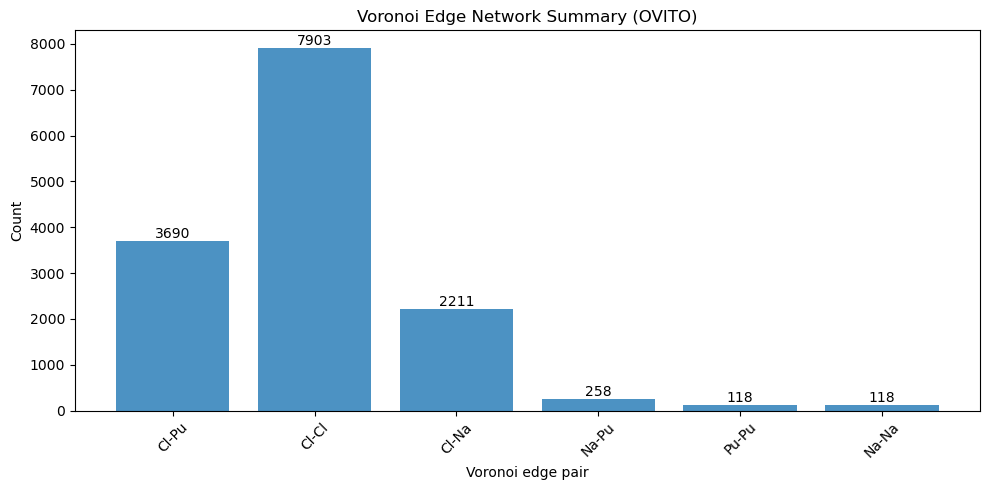

Voronoi Edge Network Summary (OVITO):
Cl-Pu: 3690 edges
Cl-Cl: 7903 edges
Cl-Na: 2211 edges
Na-Pu: 258 edges
Pu-Pu: 118 edges
Na-Na: 118 edges


Counter({('Cl', 'Cl'): 7903,
         ('Cl', 'Pu'): 3690,
         ('Cl', 'Na'): 2211,
         ('Na', 'Pu'): 258,
         ('Pu', 'Pu'): 118,
         ('Na', 'Na'): 118})

In [3]:
# Full-system Voronoi graph (OVITO pipeline)
G = build_voronoi_graph_from_pipeline(aae, frame=frame, min_area=0.0)
props = analyze_graph_properties(G)
print('Graph properties (full):', props)

# Optional: summarize Voronoi edge network
from voronoi_ovito_utils import summarize_voronoi_edge_network
pair_counts = summarize_voronoi_edge_network(G, plot=True)
pair_counts


In [4]:
# Metals-only Voronoi graph and clusters (OVITO pipeline)
metal_species = ['Pu', 'Na']  # Adjust as needed
Gm = build_voronoi_graph_metals_only_from_pipeline(aae, frame=frame, min_area=0.0, metal_species=metal_species)
print('Metals-only graph properties:', analyze_graph_properties(Gm))

# Coordination distributions over selected frames (OVITO pipeline)
frames = [frame]
coord = analyze_voronoi_coordination_from_pipeline(aae, frames=frames, at_list=None, min_area=0.0)
central = metal_species[0] if metal_species else list(coord.keys())[0]
print(f"Coordination counts for central species '{central}':")
for neighbor_sp, vals in coord.get(central, {}).items():
    if vals:
        print(neighbor_sp, '-> mean:', float(np.mean(vals)), 'std:', float(np.std(vals)))



Metals-only graph properties: {'num_nodes': 576, 'num_edges': 4384, 'density': 0.02647342995169082, 'species_counts': {'Pu': 384, 'Na': 192}, 'is_connected': True, 'diameter': 6, 'radius': 5, 'avg_degree': 15.222222222222221, 'std_degree': 2.058837470126057, 'max_degree': 21, 'min_degree': 10, 'species_avg_degrees': {'Pu': 15.3984375, 'Na': 14.869791666666666}, 'avg_facet_area': 0.0, 'std_facet_area': 0.0, 'min_facet_area': 0.0, 'max_facet_area': 0.0}
Coordination counts for central species 'Pu':
Cl -> mean: 9.609375 std: 1.3024478656392866
Na -> mean: 0.671875 std: 0.7883531258526643
Pu -> mean: 0.6145833333333334 std: 0.7341348602644854


In [5]:
# (Optional) Temporal analysis over selected frames with OVITO pipeline
# frames = list(range(0, min(aae.source.num_frames, 50), 5))
# temporal = analyze_temporal_graph_properties_from_pipeline(aae, frames=frames, min_area=0.0)
# plot_temporal_graph_properties(temporal)

print('Notebook scaffold ready. Set input_path and run cells.')



Notebook scaffold ready. Set input_path and run cells.


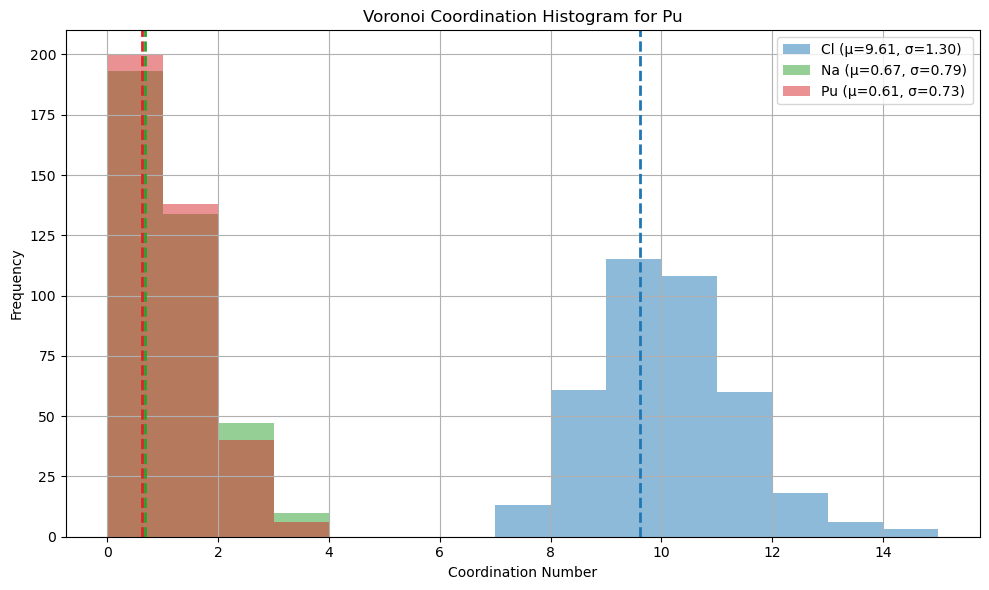

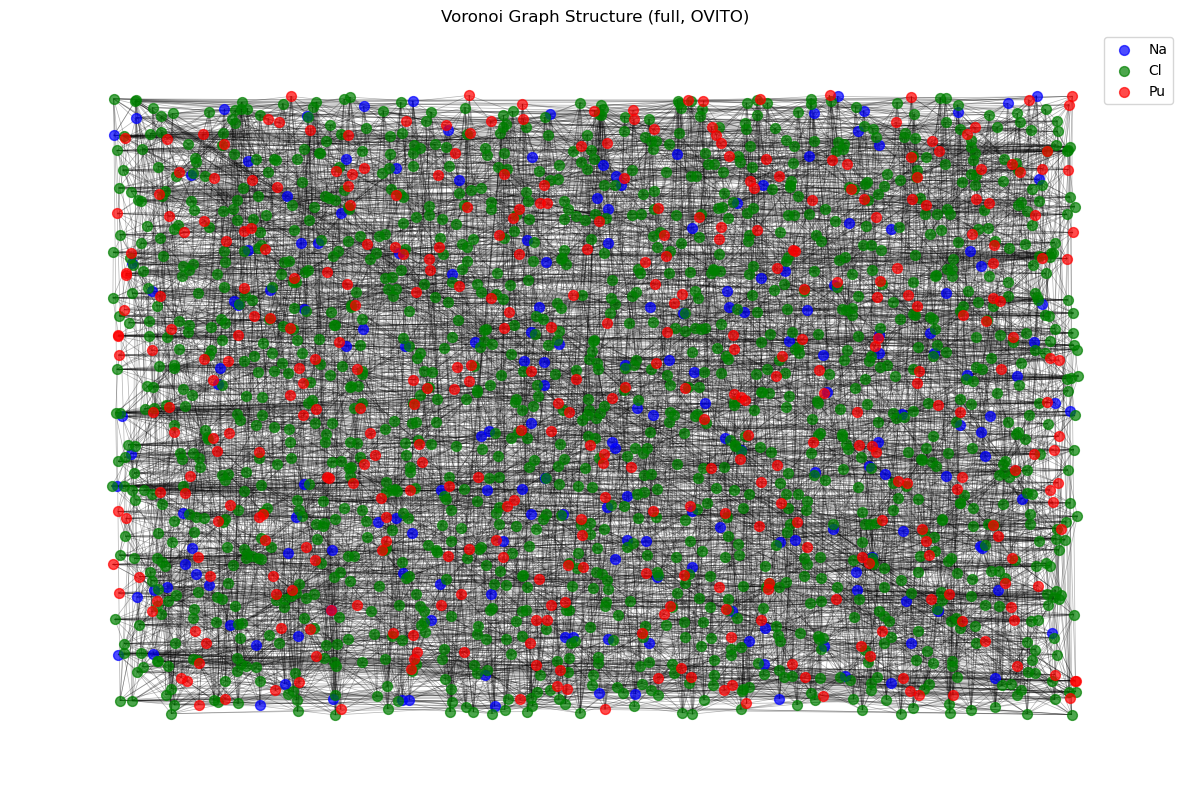

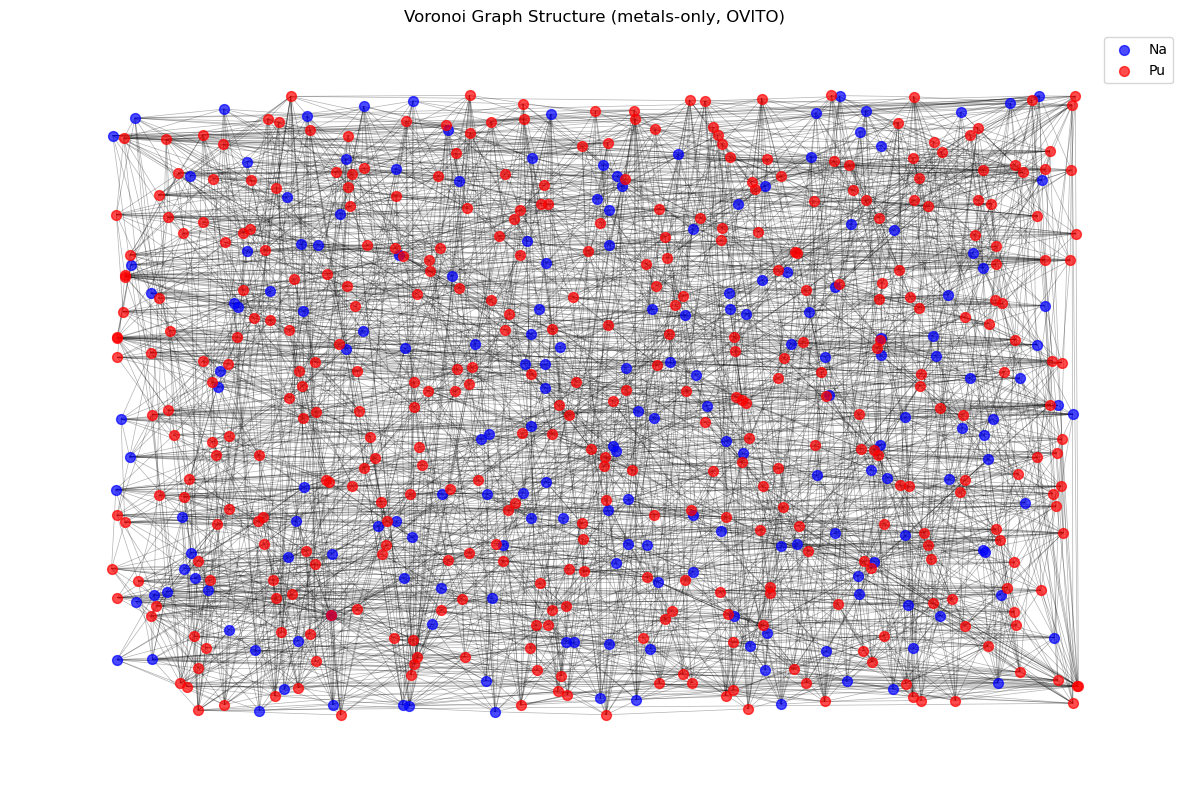

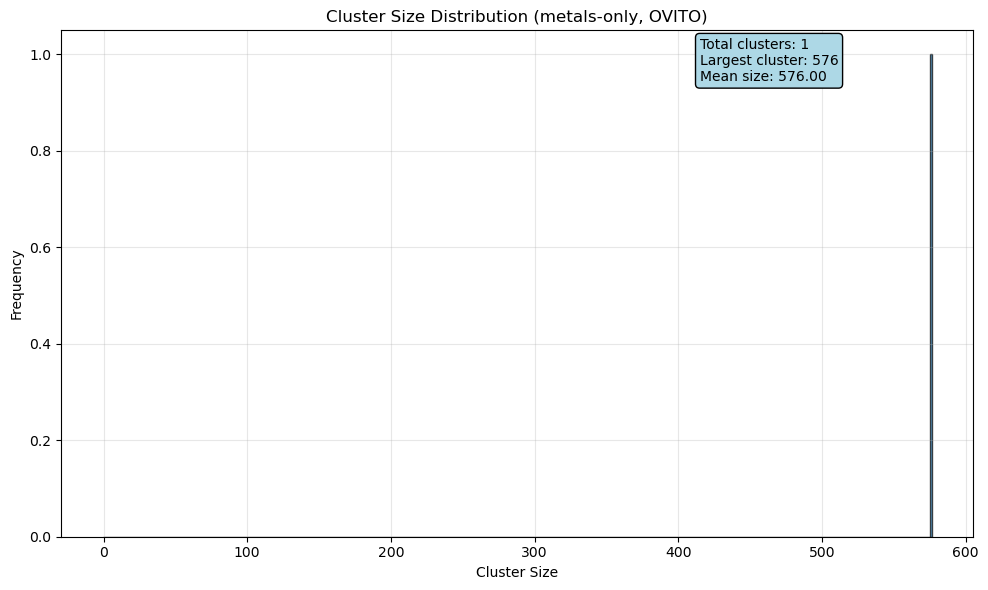

In [6]:
# Match plots from voronoi_canon
from voronoi_ovito_utils import (
    plot_coordination_histograms,
    plot_graph_structure,
    plot_cluster_size_distribution,
)

# Example coordination histogram for chosen central species (if plot_utils available)
try:
    if coord:
        plot_coordination_histograms(coord, central_type=central)
except Exception as e:
    print('Coordination histogram plotting unavailable or failed:', e)

# Graph structure plots
try:
    plot_graph_structure(G, title='Voronoi Graph Structure (full, OVITO)')
    plot_graph_structure(Gm, title='Voronoi Graph Structure (metals-only, OVITO)')
except Exception as e:
    print('Graph plotting unavailable or failed:', e)

# Cluster size distribution from metals-only graph components
try:
    comps = list(nx.connected_components(Gm))
    sizes = [len(c) for c in comps]
    if sizes:
        plot_cluster_size_distribution(sizes, title='Cluster Size Distribution (metals-only, OVITO)')
except Exception as e:
    print('Cluster size distribution plotting unavailable or failed:', e)



3D components for metals-only Voronoi graph:


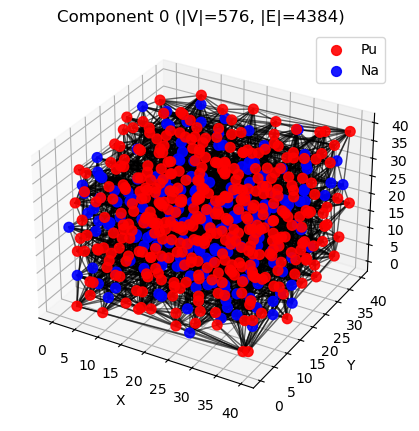

In [7]:
# 3D graph with edges (largest components)
from plot_utils import plot_3d_graph_components

# Full graph (may be dense/noisy); metals-only is typically more informative
try:
    print('3D components for metals-only Voronoi graph:')
    plot_3d_graph_components(Gm, max_components=6)
except Exception as e:
    print('3D graph plotting failed:', e)



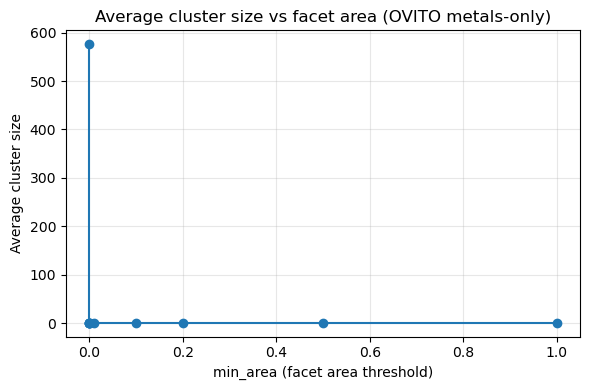

In [8]:
# Average cluster size vs facet area (min_area) sweep using OVITO pipeline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from voronoi_ovito_utils import (
    build_voronoi_graph_metals_only_from_pipeline,
)

metal_species = ['Pu', 'Na']

# # Collect edge areas at min_area=0 to set sweep range
# G0 = build_voronoi_graph_metals_only_from_pipeline(aae, frame=frame, min_area=0.0, metal_species=metal_species)
# areas0 = np.array([edata.get('area', 0.0) for _,_,edata in G0.edges(data=True)], float)

# if areas0.size == 0:
#     thresholds = np.linspace(0.0, 1.0, 201)
# else:
#     lo = float(np.quantile(areas0, 0.00))
#     hi = float(np.quantile(areas0, 0.80))
#     thresholds = np.linspace(lo, hi if hi > lo else lo + 1.0, 25)
thresholds = [0,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,0.2,0.5,1]

avg_sizes = []
for t in thresholds:
    Gm = build_voronoi_graph_metals_only_from_pipeline(aae, frame=frame, min_area=float(t), metal_species=metal_species)
    comps = list(nx.connected_components(Gm))
    sizes = np.array([len(c) for c in comps], int)
    avg_sizes.append(float(np.mean(sizes)) if sizes.size > 0 else 0.0)

plt.figure(figsize=(6,4))
plt.plot(thresholds, avg_sizes, marker='o')
plt.xlabel('min_area (facet area threshold)')
plt.ylabel('Average cluster size')
plt.title('Average cluster size vs facet area (OVITO metals-only)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
avg_sizes

[576.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

- Lower conc
- Without Na you do
- last hunder snapshots and avg them
- cluster size as a func of conc
- histogram of CN distribution
- how does avg coordination number change when you change all these parameters.

In [ ]:
- Look at distribution of coordination number
- what did we use as our thesholds